## Imports

In [293]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import numpy as np
import math

# use fmDemodArctan and fmPlotPSD
from fmSupportLib import fmDemodArctan, fmPlotPSD, own_lfilter, lpCoeff, custom_fm_demod, logVector, bpFirwin, fmPll, delayBlock, sampling_start_adjust
from fmRRC import impulseResponseRootRaisedCosine
# for take-home add your functions


In [294]:
def upsample(y, upsampling_factor):
    if upsampling_factor == 1:
        return y

    original_size = len(y)
    y_extended = np.zeros(original_size * upsampling_factor)
    y_extended[::upsampling_factor] = y

    return y_extended

## Constants

In [295]:
rf_Fs = 2.4e6
rf_Fc = 100e3
rf_taps = 101
rf_decim = 10

audio_taps = 101
audio_Fc = 16e3
audio_decim = 5
audio_Fs = 48e3

rds_bpf_fc_low = 54e3
rds_bpf_fc_high = 60e3
rds_bpf_taps = 101

rds_lpf_fc = 3e3
rds_lpf_taps = 101

rds_rrc_taps = 151

rds_upsampling_factor = 19
rds_downsampling_factor = 80
rds_decim = rds_downsampling_factor/rds_upsampling_factor

rds_squared_bpf_fc_low = 113.5e3
rds_squared_bpf_fc_high = 114.5e3
rds_carrier_frequency = 114e3
rds_squared_bpf_taps = 101

## State Variables (useless in single pass)

In [296]:
state_i_lpf_100k = np.zeros(rf_taps-1)
state_q_lpf_100k = np.zeros(rf_taps-1)
rds_filt_state_bpf = np.zeros(rds_squared_bpf_taps-1)
rds_filt_state_apf = np.zeros(int((rds_bpf_taps-1)/2))
rds_filt_state_lpf = np.zeros(rds_lpf_taps-1)
state_phase = 0
state_i_custom = np.float64(0.0)
state_q_custom = np.float64(0.0)

# INIITIAL PLL STATES
pll_state_integrator = 0.0
pll_state_phaseEst = 0.0
pll_state_feedbackI = 1.0
pll_state_feedbackQ = 0.0
pll_state_trigOffset = 0
pll_state_lastNco = 1.0

pll_state_integrator_q =  0.0
pll_state_phaseEst_q =  0.0
pll_state_feedbackI_q =  1.0
pll_state_feedbackQ_q =  0.0
pll_state_trigOffset_q =  0
pll_state_lastNco_q =  1.0

## Read In Raw Data

In [297]:
in_fname = "../data/samples9.raw"

raw_data = np.fromfile(in_fname, dtype='uint8')
print("Read raw RF data from \"" + in_fname + "\" in unsigned 8-bit format")
# IQ data is normalized between -1 and +1 in 32-bit float format
iq_data = (np.float32(raw_data) - 128.0)/128.0
print("Reformatted raw RF data to 32-bit float format (" + str(iq_data.size * iq_data.itemsize) + " bytes)")

# set up the subfigures for plotting
# subfig_height = np.array([0.8, 2, 1.6])
# plt.rc('figure', figsize=(7.5, 7.5))	
# fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, gridspec_kw={'height_ratios': subfig_height})
# fig.subplots_adjust(hspace = .6)

Read raw RF data from "../data/samples9.raw" in unsigned 8-bit format
Reformatted raw RF data to 32-bit float format (96000000 bytes)


## Calculate the filter coefficients

In [298]:
rf_coeff = signal.firwin(rf_taps, rf_Fc/(rf_Fs/2), window=('hann'))

audio_coeff = signal.firwin(audio_taps, audio_Fc/((rf_Fs/rf_decim)/2), window=('hann'))

rds_bpf_coeff = bpFirwin((rf_Fs/rf_decim), 
                            rds_bpf_fc_low, 
                            rds_bpf_fc_high, 
                            rds_bpf_taps)

rds_squared_bpf_coeff = bpFirwin((rf_Fs/rf_decim), 
                                    rds_squared_bpf_fc_low, 
                                    rds_squared_bpf_fc_high, 
                                    rds_squared_bpf_taps)

rds_lpf_coeff = signal.firwin(rds_lpf_taps, rds_lpf_fc/((rf_Fs/rf_decim)/2), window=('hann'))



rds_rrc_coeff = impulseResponseRootRaisedCosine(rf_Fs/(rf_decim*rds_decim), rds_rrc_taps)


## RF Front End

In [299]:
i_filt = signal.lfilter(rf_coeff, 1.0, iq_data[::2])
q_filt = signal.lfilter(rf_coeff, 1.0, iq_data[1::2])

i_ds = i_filt[::rf_decim]
q_ds = q_filt[::rf_decim]

fm_demod, dummy = fmDemodArctan(i_ds, q_ds)

## Audio check

In [300]:
# audio_filt = signal.lfilter(audio_coeff, 1.0, fm_demod[0])
# audio_data = audio_filt[::audio_decim] # to be updated by you during in-lab (same code for takehome)
# out_fname = "../data/fmRdsBasic_mono.wav"
# wavfile.write(out_fname, int(audio_Fs), np.int16((audio_data/2)*32767))

## RDS Data Extraction

### In phase

In [301]:
# Bandpass filter
rds_filt = signal.lfilter(rds_bpf_coeff, 1.0, fm_demod)

# square signal
rds_filt_squared = rds_filt*rds_filt

rds_filt_carrier = signal.lfilter(rds_squared_bpf_coeff, 1.0, rds_filt_squared)

ncoOut_inPhase, pll_state_integrator, pll_state_phaseEst, pll_state_trigOffset, pll_state_lastNco = fmPll(
			rds_filt_carrier, 
			rds_carrier_frequency, 
			rf_Fs/rf_decim, 
			pll_state_integrator, 
			pll_state_phaseEst,
			pll_state_feedbackI,
			pll_state_feedbackQ,
			pll_state_trigOffset, 
			pll_state_lastNco, 
			ncoScale=0.5,
			normBandwidth=0.0025)

# plt.plot(ncoOut[10000:10100])
# plt.plot(100*rds_filt_carrier[10000:10100])
# plt.show()

### Quadrature phase

In [302]:
# Bandpass filter
rds_filt_q = signal.lfilter(rds_bpf_coeff, 1.0, fm_demod)

# square signal
rds_filt_squared_q = rds_filt_q*rds_filt_q

rds_filt_carrier_q = signal.lfilter(rds_squared_bpf_coeff, 1.0, rds_filt_squared_q)

ncoOut_qPhase, pll_state_integrator_q, pll_state_phaseEst_q, pll_state_trigOffset_q, pll_state_lastNco_q = fmPll(
			rds_filt_carrier_q, 
			rds_carrier_frequency, 
			rf_Fs/rf_decim, 
			pll_state_integrator_q, 
			pll_state_phaseEst_q,
			pll_state_feedbackI_q,
			pll_state_feedbackQ_q,
			pll_state_trigOffset_q, 
			pll_state_lastNco_q, 
			ncoScale=0.5,
			normBandwidth=0.001,
            phaseAdjust=math.pi/2)

## All Pass filter rds data

In [303]:
rds_filt_delayed, rds_filt_state_apf = delayBlock(rds_filt, rds_filt_state_apf)


## RDS Demodulation

### In phase


In [304]:
# Mixer
rds_mixed = 2 * rds_filt_delayed * ncoOut_inPhase[:-1]

rds_mixed_lfiltered = signal.lfilter(rds_lpf_coeff, 1.0, rds_mixed)

rds_upsampled = upsample(rds_mixed_lfiltered, rds_upsampling_factor)

rds_upsampled_lfilterd = signal.lfilter(rds_lpf_coeff, 1.0, rds_upsampled)

rds_resampled = rds_upsampling_factor*rds_upsampled_lfilterd[::rds_downsampling_factor]

rds_rrcfiltered = signal.lfilter(rds_rrc_coeff, 1.0, rds_resampled)

### Quadrature phase

In [305]:
# Mixer
rds_mixed_q = 2 * rds_filt_delayed * ncoOut_qPhase[:-1]

rds_mixed_lfiltered_q = signal.lfilter(rds_lpf_coeff, 1.0, rds_mixed_q)

rds_upsampled_q = upsample(rds_mixed_lfiltered_q, rds_upsampling_factor)

rds_upsampled_lfilterd_q = signal.lfilter(rds_lpf_coeff, 1.0, rds_upsampled_q)

rds_resampled_q = rds_upsampling_factor*rds_upsampled_lfilterd_q[::rds_downsampling_factor]

rds_rrcfiltered_q = signal.lfilter(rds_rrc_coeff, 1.0, rds_resampled_q)

## Sampling


In [315]:
samples_per_symbol = 24
symbols_per_window = 2000
winsize = (samples_per_symbol*symbols_per_window)
winstart = 10 # BUG: there is a bug if you make this 3500 bc the start offset is sample 0. spw(100), sps(24), new_win(1)
new_win = 2 # Pick a new window
data_window_start = winstart + (samples_per_symbol*symbols_per_window*new_win)


### In Phase

sampling start offset:  9
val at offset:  -1.720060821249293
[-1.72006082  1.3000071   1.34368349 ... -1.31239758  1.35474295
 -1.50669439]


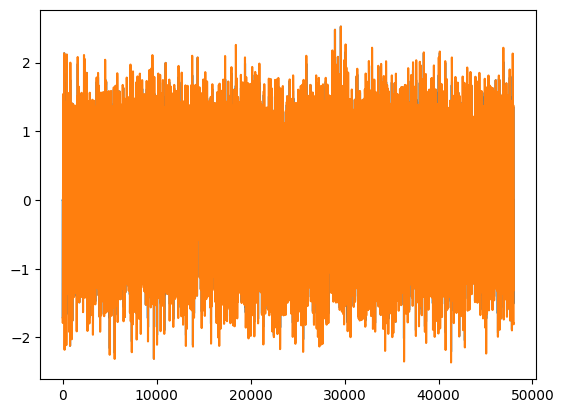

In [316]:
rrc_data_window = rds_rrcfiltered[data_window_start:data_window_start+winsize]
sampling_start_offset = sampling_start_adjust(rrc_data_window, samples_per_symbol)

print("sampling start offset: ", sampling_start_offset)
print("val at offset: ", rrc_data_window[sampling_start_offset])

sampling_points = rrc_data_window[sampling_start_offset::samples_per_symbol]
print(sampling_points)

sampling_points_graphing = upsample(np.ones(symbols_per_window), samples_per_symbol)[:-(sampling_start_offset)]
sampling_points_graphing = np.concatenate((np.zeros(sampling_start_offset), sampling_points_graphing))
sampling_points_graphing = sampling_points_graphing * rrc_data_window

plt.plot(sampling_points_graphing)
plt.plot(rrc_data_window)
plt.show()   

### Quadrature Phase

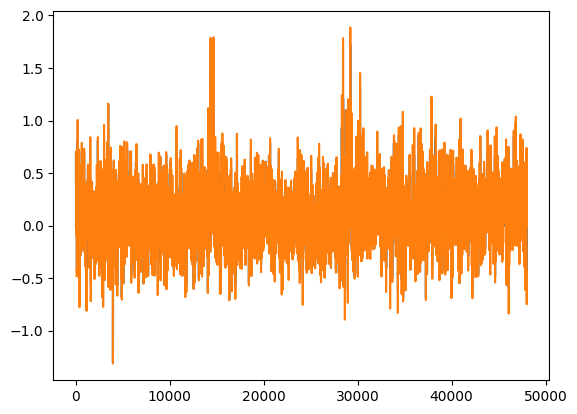

In [317]:
rrc_data_window_q = rds_rrcfiltered_q[data_window_start:data_window_start+winsize]

sampling_points_q = upsample(np.ones(symbols_per_window), samples_per_symbol)[:-(sampling_start_offset)]
sampling_points_q = np.concatenate((np.zeros(sampling_start_offset), sampling_points_q))
sampling_points_q = sampling_points_q * rrc_data_window_q

plt.plot(sampling_points_q)
plt.plot(rrc_data_window_q)
plt.show()   

## Constellation Plot

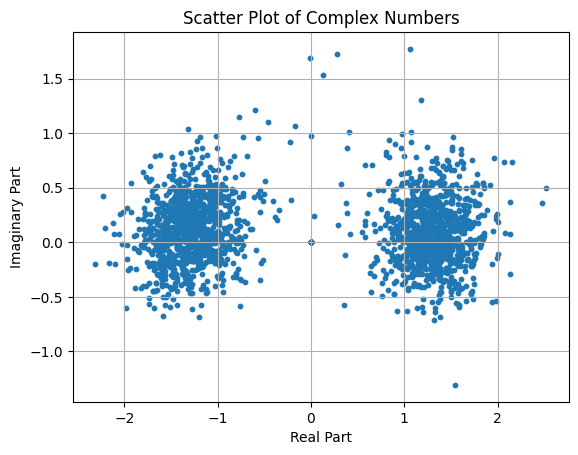

In [318]:
vals = sampling_points_graphing + 1j * sampling_points_q

plt.scatter(vals.real, vals.imag, s=10)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Scatter Plot of Complex Numbers')
plt.grid(True)
plt.show()

In [319]:
def symbol_vals_to_bits(sampling_points, offset=0):
    bool_array = np.zeros(int(len(sampling_points)/2), dtype=bool)
    hh_count = 0
    ll_count = 0
    for i in range(0, len(sampling_points)-(offset+1), 2):
        if sampling_points[i+offset] == 0 and \
            sampling_points[i+offset+1] == 0:
            print("DOUBLE ZERO WARNING")
            bool_array[int(i/2)] = bool(0)

        if sampling_points[i+offset] >= 0 and \
            sampling_points[i+offset+1] <= 0: #case HL
            bool_array[int(i/2)] = bool(1)

        elif sampling_points[i+offset] <= 0 and \
            sampling_points[i+offset+1] >= 0: #case LH
            bool_array[int(i/2)] = bool(0)

        elif sampling_points[i+offset] < 0 and \
            sampling_points[i+offset+1] < 0: #case LL
            if (sampling_points[i+offset] < sampling_points[i+offset+1]): # weak LH
                bool_array[int(i/2)] = bool(0)
            elif (sampling_points[i+offset] >= sampling_points[i+offset+1]): # weak HL
                bool_array[int(i/2)] = bool(1)
            ll_count+=1

        elif sampling_points[i+offset] > 0 and \
            sampling_points[i+offset+1] > 0: #case HH
            if (sampling_points[i+offset] > sampling_points[i+offset+1]): # weak HL
                bool_array[int(i/2)] = bool(1)
            elif (sampling_points[i+offset] <= sampling_points[i+offset+1]): # weak LH
                bool_array[int(i/2)] = bool(0)
            hh_count+=1
            
    return bool_array, ll_count, hh_count

def differential_decode(bool_array):
    decoded = np.empty(len(bool_array), dtype=bool)
    decoded[0] = bool_array[0]
    for i in range(1, len(bool_array)):
        decoded[i] = bool_array[i] ^ decoded[i-1]
    return decoded

## Recover Bitstream

In [320]:
bitstream0, ll_count0, hh_count0 = symbol_vals_to_bits(sampling_points, 0)
bitstream1, ll_count1, hh_count1 = symbol_vals_to_bits(sampling_points, 1)


print(len(sampling_points))
print(f"0: LL count: {ll_count0}, HH count: {hh_count0}")
print(f"1: LL count: {ll_count1}, HH count: {hh_count1}")

# pick the right bitstream
bitstream = bitstream1
if (ll_count0+hh_count0) < (ll_count1+hh_count1):
    bitstream  = bitstream0

print(bitstream)

2000
0: LL count: 0, HH count: 7
1: LL count: 221, HH count: 229
[False  True False  True False  True  True  True False  True  True False
 False  True False False False  True  True  True False False False False
 False False False False False  True  True False False  True  True  True
  True  True  True  True  True False  True  True  True False False  True
 False  True  True  True  True  True  True False  True  True  True False
  True  True False False  True False  True False False  True  True  True
 False False False  True  True  True  True  True  True  True  True False
 False False False False False False False  True False False  True False
  True  True  True False  True  True  True  True False  True False  True
 False  True  True  True False  True  True False False  True False False
 False  True  True  True False False False False False False False False
 False  True  True False False  True  True  True False False  True False
 False False False  True  True False  True False  True Fals

## Differential Decoding

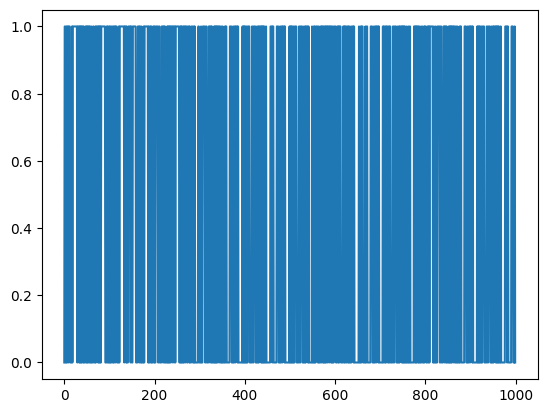

In [321]:
bitstream_decoded = differential_decode(bitstream)

plt.plot(bitstream_decoded)
plt.show()

## Frame Synchronization

In [322]:
le_ptit_matrix = np.array(
[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
 [0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
 [1, 0, 1, 0, 0, 0, 0, 1, 1, 1],
 [1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
 [1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
 [1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 [1, 1, 0, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 1, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
 [0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
 [0, 0, 1, 1, 1, 1, 0, 1, 1, 1],
 [1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
 [1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
 [1, 1, 0, 0, 0, 1, 1, 0, 1, 1]], dtype=bool)


def matrix_multiply_bool(matrix1, matrix2):
    if matrix1.ndim != 1:
        raise ValueError("matrix1 must be a 1D array")
    
    result = np.zeros(matrix2.shape[1], dtype=bool)
    
    for j in range(matrix2.shape[1]):
        for k in range(matrix2.shape[0]):
            result[j] ^= matrix1[k] & matrix2[k, j]
    
    return concat_bool_arr(result)

def concat_bool_arr(bool_arr):
    # Convert boolean array to integer
    result = 0
    for bit in bool_arr:
        result = (result << 1) | int(bit)
    return result

def matches_syndrome(ten_bit_val):
    les_syndromes = {
        'A': 0b1111011000,
        'B': 0b1111010100,
        'C': 0b1001011100,
        'Cprime': 0b1111001100,
        'D': 0b1001011000
    }

    for syndrome, value in les_syndromes.items():
        if ten_bit_val == value:
            return True, syndrome
        
    return False, None

In [325]:
print(len(bitstream_decoded))

check_len = 26
for start_idx in range(0, len(bitstream_decoded)-check_len):
    twenty_six_bit_value = bitstream_decoded[start_idx:start_idx+check_len]
    ten_bit_code = matrix_multiply_bool(twenty_six_bit_value, le_ptit_matrix)

    # print(f"{start_idx} {bin(ten_bit_code)}")

    is_valid, syndrome = matches_syndrome(ten_bit_code)
    if is_valid:
        print(f"{start_idx} found syndrome: ", syndrome)
        twenty_six_bit_value = bitstream_decoded[start_idx+check_len:start_idx+2*check_len]
        ten_bit_code = matrix_multiply_bool(twenty_six_bit_value, le_ptit_matrix)
        print(f"{start_idx} next code: ", bin(ten_bit_code))

0b1111010100

1000
27 found syndrome:  A
27 next code:  0b1100011100
141 found syndrome:  A
141 next code:  0b1110011111
207 found syndrome:  Cprime
207 next code:  0b1000000110
311 found syndrome:  Cprime
311 next code:  0b10011111
831 found syndrome:  Cprime
831 next code:  0b10011111
